# **Environment Setup and Library Installation**

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install transformers datasets evaluate scikit-learn seaborn matplotlib -q


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.7 MB/s eta 0:00:00


# **Fine-Tuning DistilBERT for Multi-Class Emotion Detection**

Loading dataset...
Dataset loaded! Shape: (22050, 2)
Columns: ['content', 'sentiment']

First few examples:
                                             content  sentiment
0                   not a very good day at the house          1
1  tommcfly i saw you on tues and last niiiighht ...          2
2     i dont even understand the intro to this book           3
3      happy mothers day mommy and grandma haha  ily          0
4  quotoh i got so fucked up last nightquot but u...          3

Emotion labels: {0: 'Joy', 1: 'Sadness', 2: 'Neutral', 3: 'Anger'}
Number of classes: 4

Class distribution:
sentiment
0    5827
1    5165
2    5209
3    5849
Name: count, dtype: int64

Splitting data...
Train size: 19845
Validation size: 2205

Loading tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizing texts...


Map:   0%|          | 0/19845 [00:00<?, ? examples/s]

Map:   0%|          | 0/2205 [00:00<?, ? examples/s]


Tokenized dataset columns: ['labels', 'input_ids', 'attention_mask']

Loading DistilBERT model...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded! Parameter count: 66,956,548

Setting up Trainer...

Starting training...



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.888300,0.807009,0.667574,0.670207
2,0.655200,0.846401,0.666213,0.662528
3,0.426500,1.030954,0.653061,0.653191



Training complete!

Evaluating model...



Validation Results:
eval_loss: 0.8070
eval_accuracy: 0.6676
eval_f1_macro: 0.6702
eval_runtime: 1.0125
eval_samples_per_second: 2177.8100
eval_steps_per_second: 68.1490
epoch: 3.0000

Generating predictions for analysis...

Detailed Classification Report:
              precision    recall  f1-score   support

         Joy     0.5515    0.6518    0.5975       583
     Sadness     0.5648    0.5659    0.5653       516
     Neutral     0.7395    0.7083    0.7235       521
       Anger     0.8620    0.7368    0.7945       585

    accuracy                         0.6676      2205
   macro avg     0.6794    0.6657    0.6702      2205
weighted avg     0.6814    0.6676    0.6720      2205



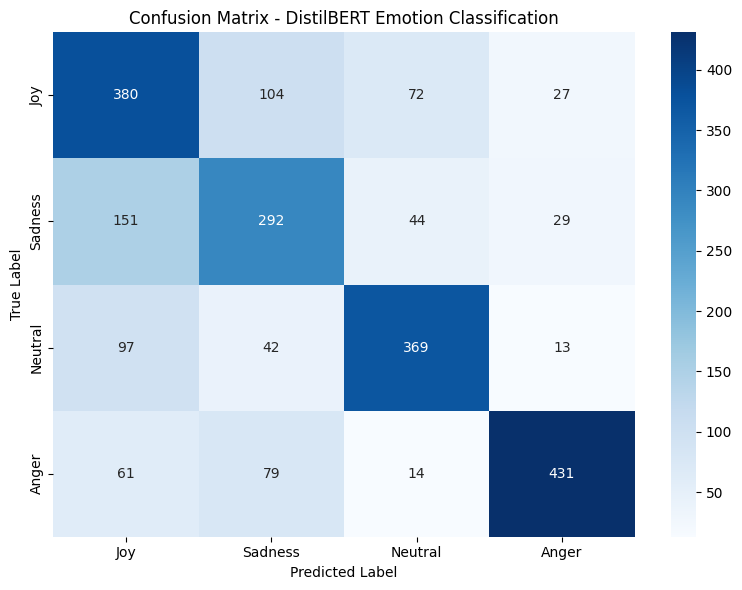


Confusion matrix saved to /content/drive/MyDrive/nlp-p2/outputs_task1/confusion_matrix.png


In [ ]:
# Import all the stuff we need
import os
import json
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
    set_seed,
)
from datasets import Dataset, DatasetDict

# Set up paths - UPDATE THIS TO YOUR DRIVE PATH
DATA_CSV = "/content/drive/MyDrive/nlp-p2/emotions-dataset.csv"
LABELS_CSV = "/content/drive/MyDrive/nlp-p2/emotion_labels.csv"
MODEL_NAME = "distilbert/distilbert-base-uncased"
OUTPUT_DIR = "/content/drive/MyDrive/nlp-p2/outputs_task1"

# Create output folder if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set random seed so results are reproducible
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
set_seed(seed)

print("Loading dataset...")
# Load the emotions dataset
df = pd.read_csv(DATA_CSV)
print(f"Dataset loaded! Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# Check first few rows
print("\nFirst few examples:")
print(df.head())

# Load emotion labels mapping
label_df = pd.read_csv(LABELS_CSV)
id2label = {int(row["label"]): row["emotion"] for _, row in label_df.iterrows()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

print(f"\nEmotion labels: {id2label}")
print(f"Number of classes: {num_labels}")

# Check class distribution
print("\nClass distribution:")
print(df["sentiment"].value_counts().sort_index())

# Split into train and validation sets (90/10 split)
print("\nSplitting data...")
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["sentiment"],
    random_state=seed
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

# Convert to HuggingFace Dataset format
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))
ds = DatasetDict({"train": train_ds, "validation": val_ds})

# Load tokenizer
print("\nLoading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
max_length = 128  # keeping it short since tweets are usually brief

# Tokenization function
def preprocess_function(examples):
    """
    This function tokenizes the text and prepares it for the model.
    We're truncating to max_length tokens to keep things consistent.
    """
    return tokenizer(
        examples["content"],
        truncation=True,
        max_length=max_length,
    )

# Tokenize all the data
print("Tokenizing texts...")
tokenized_ds = ds.map(
    preprocess_function,
    batched=True,
)

# IMPORTANT FIX: Rename 'sentiment' column to 'labels'
# The Trainer expects the label column to be called 'labels' exactly
tokenized_ds = tokenized_ds.rename_column("sentiment", "labels")

# Now remove the 'content' column since we don't need it anymore
tokenized_ds = tokenized_ds.remove_columns(["content"])

print(f"\nTokenized dataset columns: {tokenized_ds['train'].column_names}")

# Data collator handles padding dynamically
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load model with our 4-class configuration
print("\nLoading DistilBERT model...")
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    config=config
)

print(f"Model loaded! Parameter count: {model.num_parameters():,}")

# Define metrics function
def compute_metrics(eval_pred):
    """
    Calculate accuracy and F1 score for evaluation.
    Using macro F1 since we want to treat all emotions equally.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="macro")

    return {
        "accuracy": acc,
        "f1_macro": f1
    }

# Training arguments - FIXED VERSION for newer transformers
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=5e-5,  # standard learning rate for BERT-like models
    per_device_train_batch_size=16,  # adjust if you run out of memory
    per_device_eval_batch_size=32,
    num_train_epochs=3,  # project says 3-5 epochs
    weight_decay=0.01,  # some regularization
    eval_strategy="epoch",  # CHANGED: was evaluation_strategy
    save_strategy="epoch",
    load_best_model_at_end=True,  # automatically load best checkpoint
    metric_for_best_model="f1_macro",
    logging_steps=50,
    report_to="none",  # don't send to wandb or anything
    fp16=torch.cuda.is_available(),  # use mixed precision if GPU available
    save_total_limit=2,  # only keep 2 checkpoints to save space
)

# Create Trainer
print("\nSetting up Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    processing_class=tokenizer,  # UPDATED: was tokenizer, now processing_class
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Start training!
print("\n" + "="*50)
print("Starting training...")
print("="*50 + "\n")

trainer.train()

print("\nTraining complete!")

# Evaluate on validation set
print("\nEvaluating model...")
eval_results = trainer.evaluate()

print("\nValidation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")

# Save metrics to file
with open(os.path.join(OUTPUT_DIR, "eval_metrics.json"), "w") as f:
    json.dump(eval_results, f, indent=2)

# Get predictions for detailed analysis
print("\nGenerating predictions for analysis...")
predictions_output = trainer.predict(tokenized_ds["validation"])
y_true = predictions_output.label_ids
y_pred = np.argmax(predictions_output.predictions, axis=1)

# Classification report
print("\nDetailed Classification Report:")
report = classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(num_labels)],
    digits=4
)
print(report)

# Save classification report
with open(os.path.join(OUTPUT_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=[id2label[i] for i in range(num_labels)],
    yticklabels=[id2label[i] for i in range(num_labels)]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DistilBERT Emotion Classification")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix.png"), dpi=300)
plt.show()

print(f"\nConfusion matrix saved to {OUTPUT_DIR}/confusion_matrix.png")



# **Save the trained model**

In [ ]:
# Save the trained model
print("\nSaving model...")
model_save_path = os.path.join(OUTPUT_DIR, "final_model")
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path}")


Saving model...
Model saved to /content/drive/MyDrive/nlp-p2/outputs_task1/final_model


# **Test with some example sentences**

In [ ]:
# Test with some example sentences
print("\n" + "="*50)
print("Testing with example sentences")
print("="*50)

test_examples = [
    "I'm so happy and excited about this!",
    "This is making me really angry and frustrated.",
    "I feel so sad and depressed today.",
    "Just another regular day, nothing special.",
]

# Tokenize examples
test_inputs = tokenizer(
    test_examples,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

# Move to same device as model
device = model.device
test_inputs = {k: v.to(device) for k, v in test_inputs.items()}

# Get predictions
model.eval()
with torch.no_grad():
    outputs = model(**test_inputs)
    probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()

# Display results
example_predictions = []
print("\nExample Predictions:")
print("-" * 50)
for i, text in enumerate(test_examples):
    pred_label_id = int(np.argmax(probs[i]))
    pred_label = id2label[pred_label_id]
    confidence = probs[i][pred_label_id]

    print(f"\nText: {text}")
    print(f"Predicted: {pred_label} (confidence: {confidence:.2%})")
    print(f"All probabilities:")
    for label_id, prob in enumerate(probs[i]):
        print(f"  {id2label[label_id]}: {prob:.2%}")

    example_predictions.append({
        "text": text,
        "predicted_label": pred_label,
        "predicted_id": pred_label_id,
        "confidence": float(confidence),
        "all_probs": {id2label[j]: float(probs[i][j]) for j in range(num_labels)}
    })

# Save example predictions
with open(os.path.join(OUTPUT_DIR, "example_predictions.json"), "w") as f:
    json.dump(example_predictions, f, indent=2)

print("\n" + "="*50)
print("All done! Check the output folder for results.")
print(f"Output directory: {OUTPUT_DIR}")
print("="*50)


Testing with example sentences

Example Predictions:
--------------------------------------------------

Text: I'm so happy and excited about this!
Predicted: Neutral (confidence: 93.41%)
All probabilities:
  Joy: 3.94%
  Sadness: 2.32%
  Neutral: 93.41%
  Anger: 0.33%

Text: This is making me really angry and frustrated.
Predicted: Anger (confidence: 89.81%)
All probabilities:
  Joy: 2.95%
  Sadness: 6.96%
  Neutral: 0.28%
  Anger: 89.81%

Text: I feel so sad and depressed today.
Predicted: Sadness (confidence: 88.98%)
All probabilities:
  Joy: 7.92%
  Sadness: 88.98%
  Neutral: 0.83%
  Anger: 2.27%

Text: Just another regular day, nothing special.
Predicted: Sadness (confidence: 50.37%)
All probabilities:
  Joy: 42.25%
  Sadness: 50.37%
  Neutral: 5.40%
  Anger: 1.98%

All done! Check the output folder for results.
Output directory: /content/drive/MyDrive/nlp-p2/outputs_task1


# **Interactive Emotion Detection Interface using Gradio**

In [ ]:
# Install gradio first if you haven't
!pip install gradio -q

import gradio as gr
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load your trained model from the saved path
MODEL_PATH = "/content/drive/MyDrive/nlp-p2/outputs_task1/final_model"

print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()

print(f"Model loaded successfully on {device}!")

# Emotion labels mapping
id2label = {0: "Joy", 1: "Sadness", 2: "Neutral", 3: "Anger"}

def predict_emotion(text):
    """
    Main function that takes text and returns emotion predictions.
    This is what Gradio will call when someone enters text.
    """
    # Handle empty input
    if not text.strip():
        return {"Error": "Please enter some text!"}

    # Tokenize the input text
    inputs = tokenizer(
        text,
        truncation=True,
        max_length=128,
        padding=True,
        return_tensors="pt"
    )

    # Move inputs to the same device as model
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get predictions from the model
    with torch.no_grad():
        outputs = model(**inputs)
        # Convert logits to probabilities using softmax
        probs = torch.softmax(outputs.logits, dim=-1)[0].cpu().numpy()

    # Create a dictionary with emotion names and their confidence scores
    result = {id2label[i]: float(probs[i]) for i in range(len(id2label))}

    return result

# Example texts to show users how it works
examples = [
    ["I'm so happy and excited about this amazing news!"],
    ["This is really frustrating and making me so angry."],
    ["I feel so sad and lonely today."],
    ["Just a normal day, nothing special happening."],
    ["I love spending time with my friends and family!"],
    ["Why does everything always go wrong? This is annoying!"],
    ["Feeling grateful for all the good things in life."],
    ["I can't believe this happened. I'm furious!"],
]

# Create the Gradio interface
print("Creating Gradio interface...")

demo = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Textbox(
        lines=3,
        placeholder="Type or paste any text here to detect its emotion...",
        label="Input Text"
    ),
    outputs=gr.Label(
        num_top_classes=4,  # Show all 4 emotions
        label="Predicted Emotion (with confidence scores)"
    ),
    title="🎭 Emotion Detection with DistilBERT",
    description="""
    This model classifies text into 4 emotions: **Joy**, **Sadness**, **Neutral**, and **Anger**.

    Just type any sentence and the model will predict which emotion it expresses with confidence scores!

    Built using DistilBERT fine-tuned on emotions dataset.
    """,
    examples=examples,
    theme="soft",  # You can change to "default", "huggingface", etc.
    allow_flagging="never"  # Disable the flagging button
)

# Launch the interface
# share=True creates a temporary public link (lasts 72 hours)
print("\nLaunching Gradio interface...")
demo.launch(share=True, debug=True)


Loading model and tokenizer...
Model loaded successfully on cuda!
Creating Gradio interface...


/usr/local/lib/python3.12/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(



Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://e111e99700cee41a6c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
